In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# '''
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# '''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Using haar cascade to detect faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.
We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [16]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier(r"E:\Imarticus\tensorgo\haarcascades\haarcascade_frontalface_default.xml")

In [55]:
import matplotlib.pyplot as plt
#trying it out on a sample image
# img = cv2.imread(r"E:\Imarticus\tensorgo\images\maksssksksss244.png")
cap = cv2.VideoCapture(0)

while True:
    # Read the frame
    _, img = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_model.detectMultiScale(gray, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Display
    cv2.imshow('img', img)
    # Stop if escape key is pressed
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
# Release the VideoCapture object
cap.release()
cv2.destroyAllWindows()

# img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# faces = face_model.detectMultiScale(img) #returns a list of (x,y,w,h) tuples

# out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

# #plotting
# for (x,y,w,h) in faces:
#     cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
# plt.figure(figsize=(10,10))
# plt.imshow(out_img)

# Detecting social distancing violations
This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red.
MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

In [56]:
MIN_DISTANCE = 100

In [57]:
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No faces detected")

No faces detected


# Using mobilenet_v2 for mask detection


In [58]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
#augmentation
train_dir = "E:/Imarticus/tensorgo/Face Mask Dataset/Train"
test_dir = "E:/Imarticus/tensorgo/Face Mask Dataset/Test"
val_dir = "E:/Imarticus/tensorgo/Face Mask Dataset/Validation"

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [60]:
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(128,128,3))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 40962     
                                                                 
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")
history = model.fit_generator(generator=train_generator,steps_per_epoch=len(train_generator)//32,epochs=5,validation_data=val_generator,validation_steps=len(val_generator)//32)

C:\Users\ajaya\AppData\Local\Temp/ipykernel_9448/1167892390.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,steps_per_epoch=len(train_generator)//32,epochs=5,validation_data=val_generator,validation_steps=len(val_generator)//32)


Epoch 1/5
9/9 [==============================] - 20s 2s/step - loss: 1.2852 - accuracy: 0.7396
Epoch 2/5
9/9 [==============================] - 15s 2s/step - loss: 0.2084 - accuracy: 0.9618
Epoch 3/5
9/9 [==============================] - 14s 2s/step - loss: 0.2571 - accuracy: 0.9653
Epoch 4/5
9/9 [==============================] - 13s 1s/step - loss: 0.1362 - accuracy: 0.9653
Epoch 5/5
9/9 [==============================] - 12s 1s/step - loss: 0.0986 - accuracy: 0.9861


In [10]:
model.evaluate_generator(test_generator)

C:\Users\ajaya\AppData\Local\Temp/ipykernel_9448/2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.07407145202159882, 0.9887499809265137]

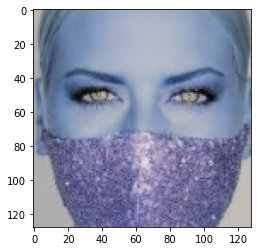

In [11]:
import matplotlib.pyplot as plt
sample_mask_img = cv2.imread(r'E:/Imarticus/tensorgo/Face Mask Dataset/Test/WithMask/45.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [12]:
model.predict(sample_mask_img)

array([[9.9810338e-01, 5.9512546e-05]], dtype=float32)

In [13]:
model.save('masknet.h5')

# Integrating with haar cascade
We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [14]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [61]:
"""if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")"""
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("no face detected")

no face detected


# live mask detection

In [62]:
from IPython.utils import io
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
CATEGORIES = {0:'MASK',1:'NO MASK'}

face_cascade = cv2.CascadeClassifier(r"E:\Imarticus\tensorgo\haarcascades\haarcascade_frontalface_default.xml")
cap = cv2.VideoCapture(0)
prevDisp = 'placeholder'
while True:
    _, frame = cap.read()
    
    mirror = cv2.flip(frame, 1)
    faces = face_cascade.detectMultiScale(mirror, 1.1, 4)
    for x, y , w, h in faces:
        img = mirror[y:y+h,x:x+w]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threed = np.repeat(gray[...,np.newaxis], 3, -1)
        preprocessed = preprocess_input(threed)
        resized = cv2.resize(preprocessed, (128,128))
        with io.capture_output() as captured:
            predictions = model.predict(np.expand_dims(resized, axis=0))
        accuracy = str(round(predictions.max(), 2))
        predicted = CATEGORIES[predictions.argmax()]
        cv2.rectangle(mirror, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(mirror, predicted, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2) 
        cv2.putText(mirror, accuracy, (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)         
    cv2.imshow('WebCam', mirror)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# social distance and id assigning

In [81]:
import cv2
import datetime
import imutils
import numpy as np
from centroid2 import CentroidTracker
from itertools import combinations
import math
from IPython.utils import io
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [28]:
CATEGORIES = {0:'MASK',1:'NO MASK'}
prevDisp = 'placeholder'

In [25]:
protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)
# Only enable it if you are using OpenVino environment
# detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker( maxDistance=90)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))


def main():
#     face_cascade = cv2.CascadeClassifier(r"E:\Imarticus\tensorgo\haarcascades\haarcascade_frontalface_default.xml")
    cap = cv2.VideoCapture(0)

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    while True:
        ret, frame1 = cap.read()
        mirror = cv2.flip(frame1, 1)
        face_cascade = cv2.CascadeClassifier(r"E:\Imarticus\tensorgo\haarcascades\haarcascade_frontalface_default.xml")
        faces = face_cascade.detectMultiScale(mirror, 1.1, 4)
        for x, y , w, h in faces:
            img = mirror[y:y+h,x:x+w]
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            threed = np.repeat(gray[...,np.newaxis], 3, -1)
            preprocessed = preprocess_input(threed)
            resized = cv2.resize(preprocessed, (128,128))
            with io.capture_output() as captured:
                predictions = model.predict(np.expand_dims(resized, axis=0))
                accuracy = str(round(predictions.max(), 2))
                predicted = CATEGORIES[predictions.argmax()]
                cv2.rectangle(mirror, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(mirror, predicted, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2) 
                cv2.putText(mirror, accuracy, (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)  
            
        frame = imutils.resize(frame1, width=600)
        total_frames = total_frames + 1

        (H, W) = frame.shape[:2]

        blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

        detector.setInput(blob)
        person_detections = detector.forward()
        rects = []
        for i in np.arange(0, person_detections.shape[2]):
            confidence = person_detections[0, 0, i, 2]
            if confidence > 0.5:
                idx = int(person_detections[0, 0, i, 1])

                if CLASSES[idx] != "person":
                    continue

                person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                (startX, startY, endX, endY) = person_box.astype("int")
                rects.append(person_box)

        boundingboxes = np.array(rects)
        boundingboxes = boundingboxes.astype(int)
        rects = non_max_suppression_fast(boundingboxes, 0.3)

        objects = tracker.update(rects)
        for (objectId, bbox) in objects.items():
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            text = "ID: {}".format(objectId)
            cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        fps_end_time = datetime.datetime.now()
        time_diff = fps_end_time - fps_start_time
        if time_diff.seconds == 0:
            fps = 0.0
        else:
            fps = (total_frames / time_diff.seconds)

        fps_text = "FPS: {:.2f}".format(fps)

        cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        cv2.imshow("Application", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

    cv2.destroyAllWindows()


main()

## shows both person and distance

In [49]:
import cv2
import datetime
import imutils
import numpy as np
from centroid2 import CentroidTracker
from itertools import combinations
import math

protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)
# detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker(maxDisappeared=2, maxDistance=50)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))


def main():
    cap = cv2.VideoCapture(0)

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    while True:
        ret, frame = cap.read()
        frame = imutils.resize(frame, width=600)
        total_frames = total_frames + 1

        (H, W) = frame.shape[:2]

        blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

        detector.setInput(blob)
        person_detections = detector.forward()
        rects = []
        for i in np.arange(0, person_detections.shape[2]):
            confidence = person_detections[0, 0, i, 2]
            if confidence > 0.5:
                idx = int(person_detections[0, 0, i, 1])

                if CLASSES[idx] != "person":
                    continue

                person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                (startX, startY, endX, endY) = person_box.astype("int")
                rects.append(person_box)

        boundingboxes = np.array(rects)
        boundingboxes = boundingboxes.astype(int)
        rects = non_max_suppression_fast(boundingboxes, 0.3)
        centroid_dict = dict()
        objects = tracker.update(rects)
        for (objectId, bbox) in objects.items():
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            cX = int((x1 + x2) / 2.0)
            cY = int((y1 + y2) / 2.0)


            centroid_dict[objectId] = (cX, cY, x1, y1, x2, y2)

            text = "ID: {}".format(objectId)
            cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        red_zone_list = []
        for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
            dx, dy = p1[0] - p2[0], p1[1] - p2[1]
            distance = math.sqrt(dx * dx + dy * dy)
            if distance < 300.0:
                if id1 not in red_zone_list:
                    red_zone_list.append(id1)
                if id2 not in red_zone_list:
                    red_zone_list.append(id2)

        for id, box in centroid_dict.items():
            if id in red_zone_list:
                cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 0, 255), 2)
            else:
                cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2)


        fps_end_time = datetime.datetime.now()
        time_diff = fps_end_time - fps_start_time
        if time_diff.seconds == 0:
            fps = 0.0
        else:
            fps = (total_frames / time_diff.seconds)

        fps_text = "FPS: {:.2f}".format(fps)

        cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        cv2.imshow("Application", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

    cv2.destroyAllWindows()


main()

# Main

In [23]:
import cv2
import datetime
import imutils
import numpy as np
from centroid2 import CentroidTracker
from itertools import combinations
import math

protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)
# detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker(maxDisappeared=2, maxDistance=50)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))


def main():
    cap = cv2.VideoCapture("test_video.mp4")

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    while True:
        ret, frame = cap.read()
        mirror = cv2.flip(frame, 1)
        face_cascade = cv2.CascadeClassifier(r"E:\Imarticus\tensorgo\haarcascades\haarcascade_frontalface_default.xml")
        faces = face_cascade.detectMultiScale(mirror, 1.1, 4)
        frame = imutils.resize(frame, width=600)
        total_frames = total_frames + 1

        (H, W) = frame.shape[:2]

        blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

        detector.setInput(blob)
        person_detections = detector.forward()
        rects = []
        for i in np.arange(0, person_detections.shape[2]):
            confidence = person_detections[0, 0, i, 2]
            if confidence > 0.5:
                idx = int(person_detections[0, 0, i, 1])

                if CLASSES[idx] != "person":
                    continue

                person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                (startX, startY, endX, endY) = person_box.astype("int")
                rects.append(person_box)

        boundingboxes = np.array(rects)
        boundingboxes = boundingboxes.astype(int)
        rects = non_max_suppression_fast(boundingboxes, 0.3)
        centroid_dict = dict()
        objects = tracker.update(rects)
        for (objectId, bbox) in objects.items():
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            cX = int((x1 + x2) / 2.0)
            cY = int((y1 + y2) / 2.0)


            centroid_dict[objectId] = (cX, cY, x1, y1, x2, y2)

            text = "ID: {}".format(objectId)
            cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        red_zone_list = []
        for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
            dx, dy = p1[0] - p2[0], p1[1] - p2[1]
            distance = math.sqrt(dx * dx + dy * dy)
            if distance < 300.0:
                if id1 not in red_zone_list:
                    red_zone_list.append(id1)
                if id2 not in red_zone_list:
                    red_zone_list.append(id2)

        for id, box in centroid_dict.items():
            if id in red_zone_list:
                cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 0, 255), 2)
            else:
                cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2)


        fps_end_time = datetime.datetime.now()
        time_diff = fps_end_time - fps_start_time
        if time_diff.seconds == 0:
            fps = 0.0
        else:
            fps = (total_frames / time_diff.seconds)

        fps_text = "FPS: {:.2f}".format(fps)

        cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)
      
        
        cv2.imshow("Application", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

    cv2.destroyAllWindows()


main()

In [68]:
def prediction(faces):
    CATEGORIES = {0:'MASK',1:'NO MASK'}
    for x, y , w, h in faces:
        img = mirror[y:y+h,x:x+w]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threed = np.repeat(gray[...,np.newaxis], 3, -1)
        preprocessed = preprocess_input(threed)
        resized = cv2.resize(preprocessed, (128,128))
        with io.capture_output() as captured:
            predictions = model.predict(np.expand_dims(resized, axis=0))
        accuracy = str(round(predictions.max(), 2))
        predicted = CATEGORIES[predictions.argmax()]
        return(cv2.rectangle(mirror, (x, y), (x+w, y+h), (0, 0, 255), 2),cv2.putText(mirror, predicted, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2) ,cv2.putText(mirror, accuracy, (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2))       
        
     

# both working

In [12]:
import numpy as np
import cv2
import datetime
import imutils
from centroid2 import CentroidTracker
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import argparse
import time
import os

In [13]:
proto_txt_path = r"E:\Imarticus\tensorgo\deploy.prototxt"
model_path = r"E:\Imarticus\tensorgo\res10_300x300_ssd_iter_140000.caffemodel"
face_detector = cv2.dnn.readNetFromCaffe(proto_txt_path, model_path)

In [20]:
cap = cv2.VideoCapture("test_video.mp4")

fps_start_time = datetime.datetime.now()
fps = 0
total_frames = 0

while(True):

    ret, frame = cap.read()
    frame = imutils.resize(frame, width=400)
    total_frames = total_frames + 1
    (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)
    detector.setInput(blob)
    person_detections = detector.forward()
    rects = []
    
    blob2 = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177, 123))
    face_detector.setInput(blob2)
    detections = face_detector.forward()
    faces = []
    b_box = []
    results = []

    for i in np.arange(0, person_detections.shape[2]):
        confidence = person_detections[0, 0, i, 2]
        
        if confidence > 0.5:
            idx = int(person_detections[0, 0, i, 1])
            
            if CLASSES[idx] != "person":
#                 new_text = "No person Detected"
#                 cv2.putText(frame, new_text, (5, 60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)
                continue

            
            person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = person_box.astype("int")
            rects.append(person_box)

    boundingboxes = np.array(rects)
    boundingboxes = boundingboxes.astype(int)
    rects = non_max_suppression_fast(boundingboxes, 0.3)

        #             cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)

    objects = tracker.update(rects)
    for (objectId, bbox) in objects.items():
        x1, y1, x2, y2 = bbox
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        text = "Person ID: {}".format(objectId)
        cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = box.astype("int")

            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            faces.append(face)
            b_box.append((startX, startY, endX, endY))
    label = {0:'MASK',1:'NO MASK'}
    if len(faces) > 0:
#         results = mask_detector.predict(faces)
         label = [0 for i in range(len(faces))]
        # new_img = cv2.cvtColor(faces, cv2.COLOR_RGB2BGR) #colored output image
         for i in range(len(faces)):
#             (x,y,w,h) = faces[i]
            faces[i] = new_img[y:y+h,x:x+w]
            crop = cv2.resize(crop,(128,128))
            crop = np.reshape(crop,[1,128,128,3])/255.0
            result = model.predict(crop)
#             cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
#             cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)

            for (face_box, result) in zip(b_box, mask_result):
        #         (startX, startY, endX, endY) = face_box
#                 (mask, withoutMask) = result

#                 label = ""
#                 if mask > withoutMask:
#                     label = "Mask"
#                     color = (0, 255, 0)
#                 else:
#                     label = "No Mask"
#                     color = (0, 0, 255)

                cv2.putText(frame, label[result.argmax()], (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

# #         cv2.imshow("Frame", frame)
               

                
    fps_end_time = datetime.datetime.now()
    time_diff = fps_end_time - fps_start_time
    if time_diff.seconds == 0:
        fps = 0.0
    else:
        fps = (total_frames / time_diff.seconds)

    fps_text = "FPS: {:.2f}".format(fps)

    cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

#     cv2.imshow("Application", frame)
    # displaying the frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        # breaking the loop if the user types q
        # note that the video window must be highlighted!
        break

cap.release()
cv2.destroyAllWindows()
# the following is necessary on the mac,
# maybe not on other platforms:
# cv2.waitKey(1)

NameError: name 'new_img' is not defined

In [21]:
cap = cv2.VideoCapture("test_video.mp4")

fps_start_time = datetime.datetime.now()
fps = 0
total_frames = 0

while(True):

    ret, frame = cap.read()
    frame = imutils.resize(frame, width=400)
    total_frames = total_frames + 1
    (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)
    detector.setInput(blob)
    person_detections = detector.forward()
    rects = []
    
    blob2 = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177, 123))
    face_detector.setInput(blob2)
    detections = face_detector.forward()
    faces = []
    b_box = []
    results = []

    for i in np.arange(0, person_detections.shape[2]):
        confidence = person_detections[0, 0, i, 2]
        
        if confidence > 0.5:
            idx = int(person_detections[0, 0, i, 1])
            
            if CLASSES[idx] != "person":
#                 new_text = "No person Detected"
#                 cv2.putText(frame, new_text, (5, 60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)
                continue

            
            person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = person_box.astype("int")
            rects.append(person_box)

    boundingboxes = np.array(rects)
    boundingboxes = boundingboxes.astype(int)
    rects = non_max_suppression_fast(boundingboxes, 0.3)

        #             cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)

    objects = tracker.update(rects)
    for (objectId, bbox) in objects.items():
        x1, y1, x2, y2 = bbox
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        text = "Person ID: {}".format(objectId)
        cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = box.astype("int")

            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            faces.append(face)
            b_box.append((startX, startY, endX, endY))

    if len(faces) > 0:
#         results = mask_detector.predict(faces)
#          label = [0 for i in range(len(faces))]
         for i in range(len(faces)):
#             (x,y,w,h) = faces[i]
#             crop = new_img[y:y+h,x:x+w]
#             crop = cv2.resize(crop,(128,128))
#             crop = np.reshape(crop,[1,128,128,3])/255.0
            mask_result = mask_detector.predict(faces[i])
#             cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
#             cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)

            for (face_box, result) in zip(b_box, mask_result):
        #         (startX, startY, endX, endY) = face_box
                (mask, withoutMask) = result

                label = ""
                if mask > withoutMask:
                    label = "Mask"
                    color = (0, 255, 0)
                else:
                    label = "No Mask"
                    color = (0, 0, 255)

                cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

# #         cv2.imshow("Frame", frame)
               

                
    fps_end_time = datetime.datetime.now()
    time_diff = fps_end_time - fps_start_time
    if time_diff.seconds == 0:
        fps = 0.0
    else:
        fps = (total_frames / time_diff.seconds)

    fps_text = "FPS: {:.2f}".format(fps)

    cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

#     cv2.imshow("Application", frame)
    # displaying the frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        # breaking the loop if the user types q
        # note that the video window must be highlighted!
        break

cap.release()
cv2.destroyAllWindows()
# the following is necessary on the mac,
# maybe not on other platforms:
# cv2.waitKey(1)

NameError: name 'mask_detector' is not defined